### Plot for Lecture Slides

In [2]:
%matplotlib inline

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

### Linear Regression

In [21]:
sns.regplot?

Minimial Cost (l2 Norm) = 13.76


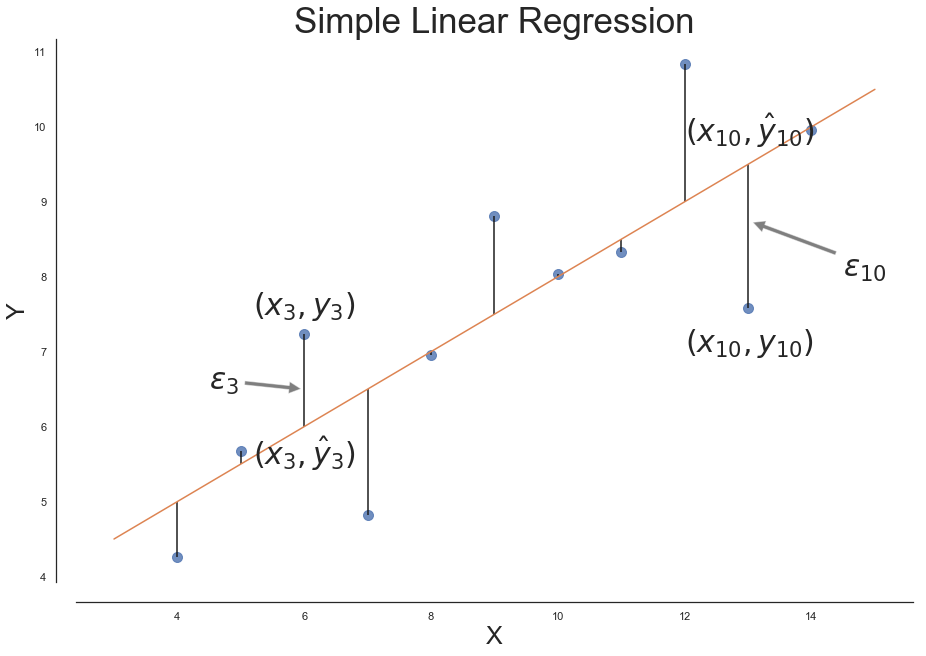

In [27]:
# Load Anscombe's Quartet
adf = sns.load_dataset("anscombe")

# Select only the first data set
adfi = adf[adf.dataset == 'I']

# Extract the x & y columns as NumPy arrays, 
# we call them xx and yy to avoid conflict with the tips data
xx = adfi.x.as_matrix()
yy = adfi.y.as_matrix()

# Number of data points
n = xx.shape[0]

# Determine mean values
mux = np.mean(xx)
muy = np.mean(yy)

# Determine best fit model parameters (from simple linear regression)
beta = np.sum((xx - mux) * (yy - muy)) / np.sum((xx - mux)**2)
alpha = muy - beta * mux

fig,ax=plt.subplots(figsize=(15,10))
# Plot the data as a Regression Plot
ax = sns.regplot(x='x', y='y', data=adfi, fit_reg=False, scatter_kws={"s": 100})

# Label plot
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_title('Simple Linear Regression', fontsize=35)

# Compute and draw epsilons
fy = beta * xx + alpha
ax.vlines(xx, yy, fy)

print(f'Minimial Cost (l2 Norm) = {np.sum((fy - yy)**2):5.2f}')

# Annotate third point
ax.annotate(r'$(x_3, y_3)$', xy=(6, 7), xytext=(5.2, 7.5),size=30)
ax.annotate(r'$(x_3, \hat{y}_3)$', xy=(6, 7), xytext=(5.2, 5.5),size=30)

ax.annotate(r'$\epsilon_3$', xy=(6, 6.5), xytext=(4.5, 6.5),
            arrowprops=dict(facecolor='black', alpha =0.5, shrink = 0.05),size=30)

# Annotate tenth point
ax.annotate(r'$(x_{10}, y_{10})$', xy=(13, 7.5), xytext=(12, 7.0),size=30)
ax.annotate(r'$(x_{10}, \hat{y}_{10})$', xy=(13, 7.5), xytext=(12, 9.8),size=30)

ax.annotate(r'$\epsilon_{10}$', xy=(13, 8.75), xytext=(14.5, 8.0),
            arrowprops=dict(facecolor='black', alpha =0.5, shrink = 0.05),size=30)

# Compute and plot linear model
xx = np.arange(3, 16)
yy = beta * xx + alpha
ax.plot(xx, yy)

#sns.despine(offset = 2, trim=True)
sns.despine(offset = 20)

### Support Vector Machine

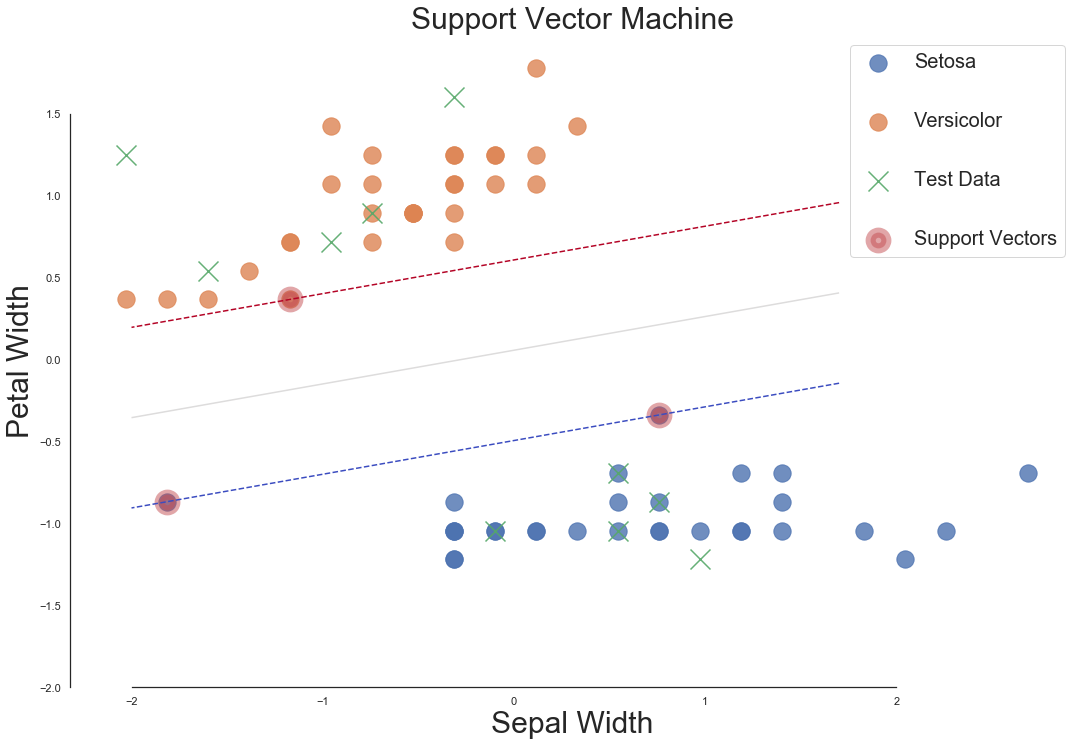

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris_df = sns.load_dataset('iris')
#create new column to hold encoded species
iris_df['species_cat'] = LabelEncoder().fit_transform(iris_df.species)

#Only keep Setosa and Versicolor data
setosa_versicolor = iris_df[iris_df.species_cat < 2]

#Define data and label

data = setosa_versicolor[['sepal_width', 'petal_width']]
label = setosa_versicolor['species_cat']

# Split data into training and testing
d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)

# Standardize data
sc = StandardScaler().fit(d_train)

d_train_sc = sc.transform(d_train)
d_test_sc = sc.transform(d_test)

from sklearn.svm import SVC
from matplotlib import cm

# Fit the model, don't regularize for illustration purposes
iris_model = SVC(kernel='linear', C=1E6)
iris_model.fit(d_train_sc, l_train)

# Number of training samples to show in plot
num_show = 10

# Now we create our figure and axes for the plot we will make.
fig, ax = plt.subplots(figsize=(18, 12))
        
# Select features from training data to plot
x = d_train_sc[:, 0]
y = d_train_sc[:, 1]

# Labels for instances
iris_name = ['Setosa', 'Versicolor']

# Iterate over types of instances, plotting each separately
for idx in np.unique(l_train):
    i = int(idx)
    ax.scatter(x[l_train == i], y[l_train == i], 
               label=f'{iris_name[idx]}',
               s=300, alpha = .8, cmap=cm.coolwarm) 

# Now plot the test data differently
xx = d_test_sc[:num_show, 0]
yy = d_test_sc[:num_show, 1]
ax.scatter(xx, yy, label='Test Data',
           marker='x', s=400, alpha = .9, cmap=cm.coolwarm) 

# Create grid to evaluate model
xx = np.linspace(-2, 1.7, 30)
yy = np.linspace(-2, 1.7, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# Predict on this grid
ZZ = iris_model.decision_function(xy)

# Take the grid and construct the hyperplanes 
# by treating them as contours. Note that we only select 
# the first and third hyperplane, otherwise plot becomes
# too busy.
z = ZZ.reshape(XX.shape)

# Plot hyperplanes
ax.contour(XX, YY, z, levels=[-1, 0, 1], 
           alpha=1, linewidth=100,linestyles=['--', '-', '--'],
           cmap=cm.coolwarm) 

# Plot support vector data points.
ax.scatter(iris_model.support_vectors_[:, 0], 
           iris_model.support_vectors_[:, 1], 
           s=250, linewidth=10, alpha=0.5, cmap=cm.coolwarm,
           label='Support Vectors')

# Decorate and clean plot
ax.set_xlabel('Sepal Width', fontsize=30)
ax.set_ylabel('Petal Width', fontsize=30)
ax.legend(loc = 'best', labelspacing=2, fontsize=20)
ax.set_title("Support Vector Machine", fontsize=30)

sns.despine(offset=0, trim=True)

### Elbow Method

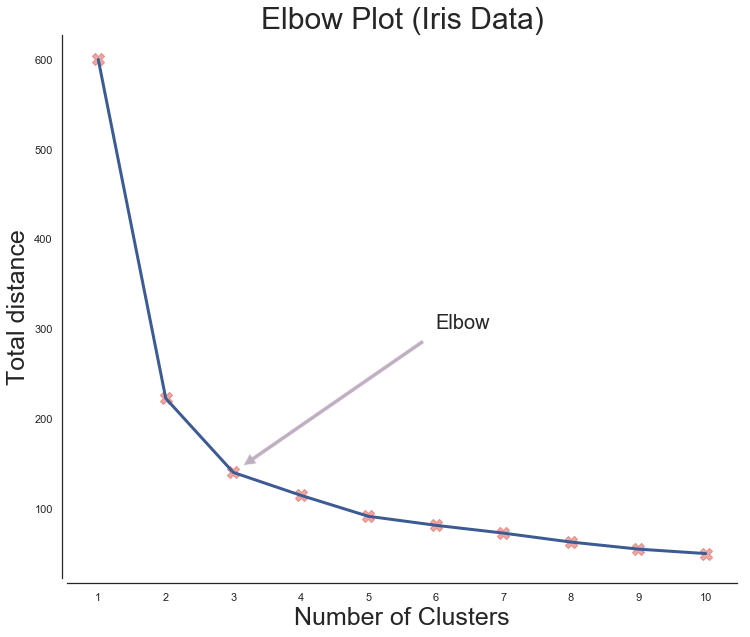

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

# Load the digits data
iris = sns.load_dataset('iris')
    
# standardize the features
x = StandardScaler().fit_transform(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
# encode species to get labels, this is for visulization only
y = LabelEncoder().fit_transform(iris.species)

# Search for best number of clusters, from one to ten
n_clusters = np.arange(1, 11)
distances = np.zeros(n_clusters.shape[0])

# Perform k-means clustering for different numbers of clusters
# Use the inertia (or sum of total distances between points
# and cluster centers) as the performance metric.
for idx, nc in enumerate(n_clusters):
    # We build our model for nc clusters
    model = KMeans(n_clusters=nc, n_init=10, random_state=23)
    model.fit(x)
    distances[idx] = model.inertia_
    
# Plot elbow method
fig, ax = plt.subplots(figsize=(12, 10))

# Draw points and connect them
ax.scatter(n_clusters, distances, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_clusters, distances, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'])

# Define elbow at three clusters
elb = (n_clusters[2], distances[2])

# Draw an arrow showing the elbow
ax.annotate('Elbow', xytext=[6, 300], xy=elb,
                arrowprops=dict(facecolor=sns.xkcd_rgb['dusty purple'], 
                                alpha=0.5, shrink=0.05), size=20)

# Decorate Plot
ax.set_title('Elbow Plot (Iris Data)',size=30) 
ax.set_xlabel('Number of Clusters', size=25)
ax.set_ylabel('Total distance', size=25)
ax.set_xticks(ticks=[1,2,3,4,5,6,7,8,9,10], minor=False)
sns.despine(offset=5)

### Time Series

In [6]:
from datetime import datetime

df = pd.read_csv('beijing_2010_2014.csv')
df['TS'] = pd.to_datetime(df.apply(lambda x:
                                   datetime(int(x.year), int(x.month), int(x.day), int(x.hour)),
                                   axis=1))
df.index = pd.DatetimeIndex(df.TS)
df.drop(['year', 'month', 'day', 'hour', 'TS'], axis=1, inplace=True)

df['pm2.5'] = df['pm2.5'].interpolate(method='time', limit_direction='both')


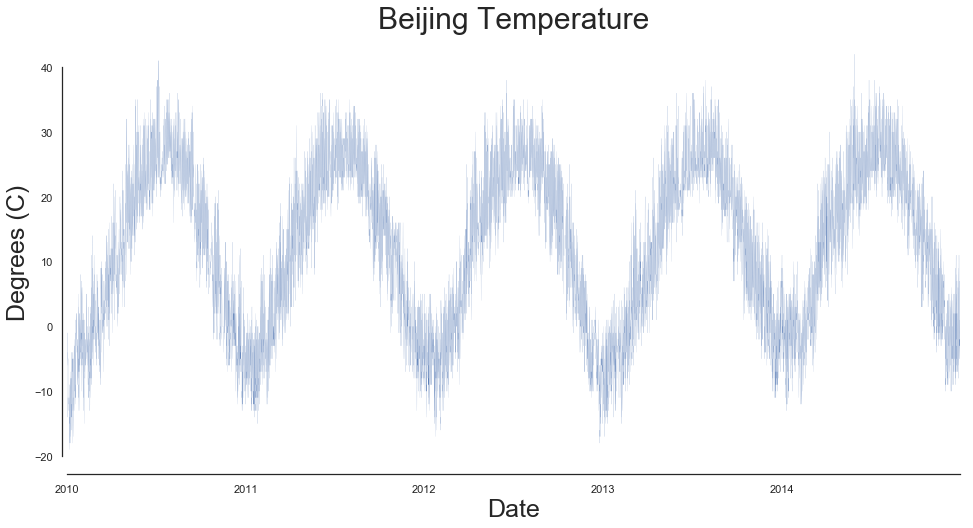

In [7]:
# Plot Temperature 
fig, ax = plt.subplots(figsize=(16, 8))

df.TEMP.plot(lw=0.1, alpha=0.9)

ax.set_title('Beijing Temperature', size=30)
ax.set_xlabel('Date',size=25)
ax.set_ylabel('Degrees (C)', size=25)

sns.despine(offset=5, trim=True)

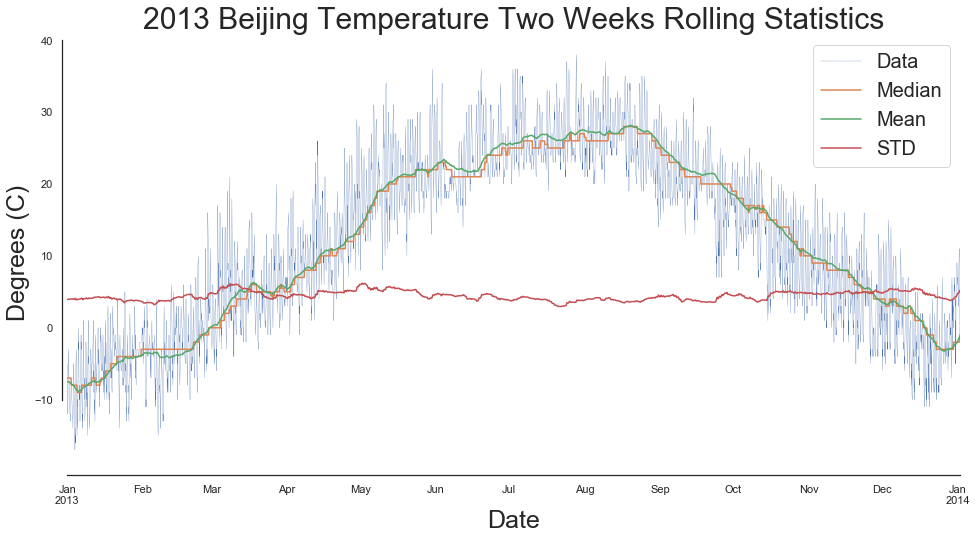

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
roll_df = df.rolling(24*14)
mn = roll_df.mean()
md = roll_df.median()
std = roll_df.std()
df.TEMP['2013-01-01':'2014-01-01'].plot(lw=0.25, label='Data')
md.TEMP['2013-01-01':'2014-01-01'].plot(label='Median')
mn.TEMP['2013-01-01':'2014-01-01'].plot(label='Mean')
std.TEMP['2013-01-01':'2014-01-01'].plot(label='STD')

ax.set_title('2013 Beijing Temperature Two Weeks Rolling Statistics',size=30)
ax.set_xlabel('Date',size=25)
ax.set_ylabel('Degrees (C)',size=25)

ax.legend(loc=1, fontsize=20)

sns.despine(offset=5, trim=True)

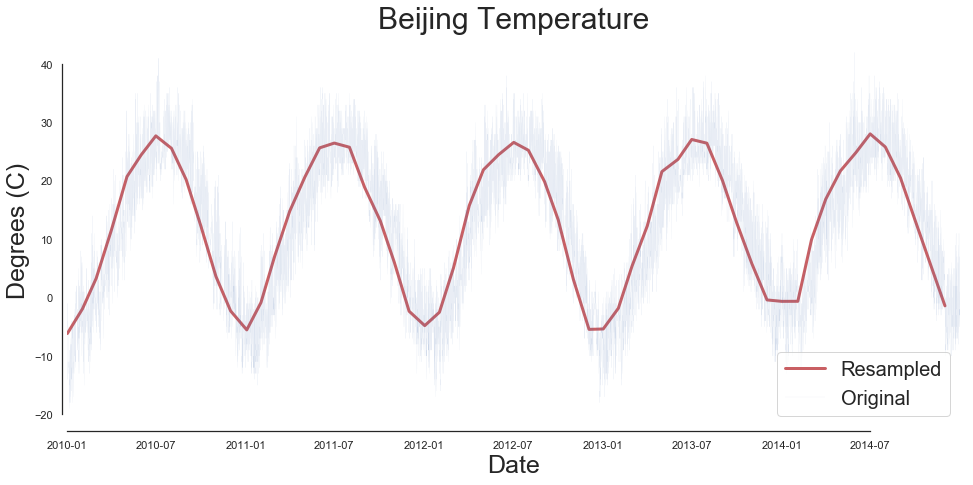

In [9]:
#resampling
fig, ax = plt.subplots(figsize=(16, 8))

df.TEMP.resample('BMS').mean().plot(lw=3, alpha=0.9, color='r', label='Resampled', ax=ax)
df.TEMP.plot(lw=0.1, alpha=0.3, label='Original', ax=ax)

ax.set_title('Beijing Temperature',size=30)
ax.set_xlabel('Date',size=25)
ax.set_ylabel('Degrees (C)', size=25)

ax.legend(loc=4,fontsize=20)
sns.despine(offset=5, trim=True)

In [10]:
#seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
#df1 = df.resample('MS').mean()
#start, end = '2010-01-01','2014-01-01'
df1 = df
start, end = '2010-06-01','2010-06-07'

decomposition = seasonal_decompose(df1.TEMP)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

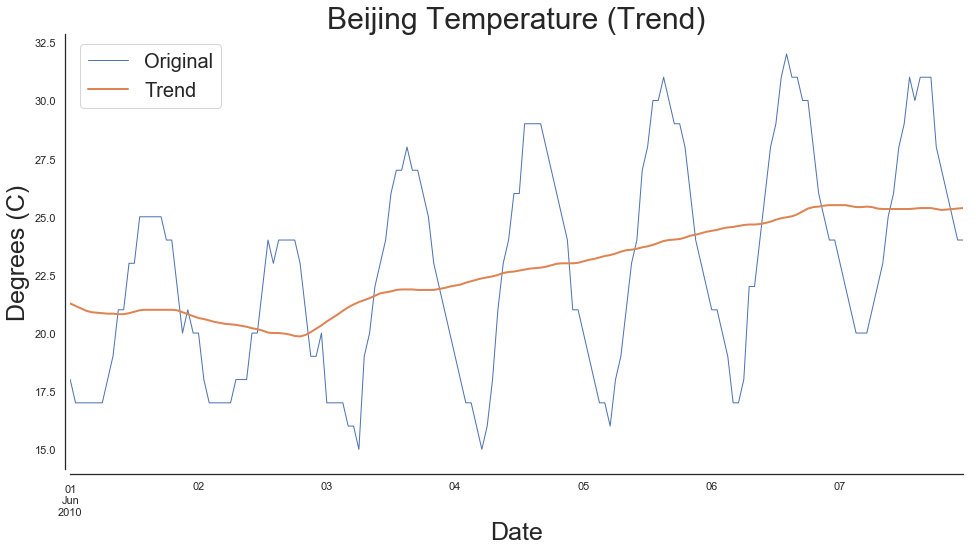

In [11]:
#### Plot one year's temperature data
fig, ax = plt.subplots(figsize=(16, 8))
df1[start:end].TEMP.plot(lw=1, alpha=1, label='Original')
trend[start:end].plot(lw=2, alpha=1, label='Trend')

ax.set_title('Beijing Temperature (Trend)',size=30)
ax.set_xlabel('Date',size=25)
ax.set_ylabel('Degrees (C)',size=25)

ax.legend(fontsize=20)
sns.despine(offset=5)

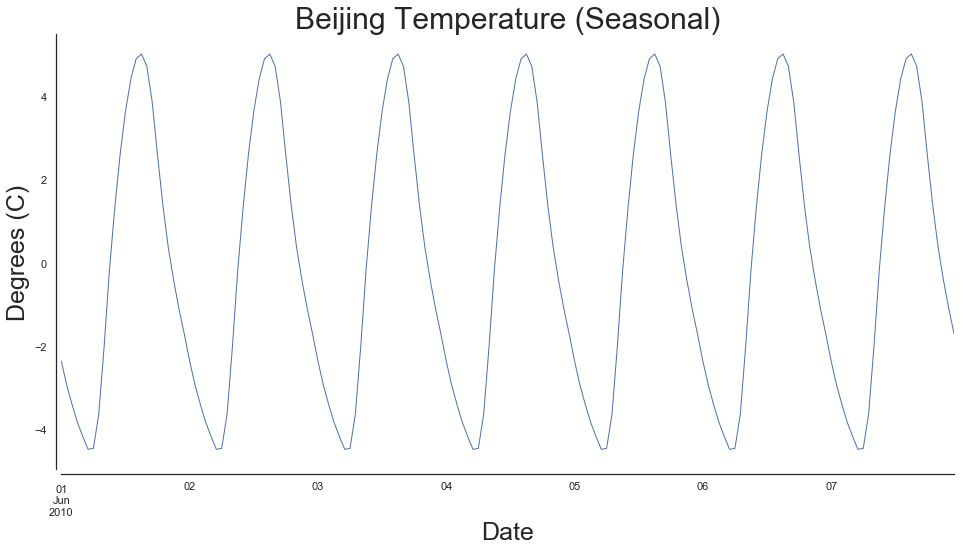

In [12]:
# Plot one month's temperature data
fig, ax = plt.subplots(figsize=(16, 8))

seasonal[start:end].plot(lw=1, alpha=1)

ax.set_title('Beijing Temperature (Seasonal)',size=30)
ax.set_xlabel('Date',size=25)
ax.set_ylabel('Degrees (C)',size=25)

sns.despine(offset=5)#, trim=True)

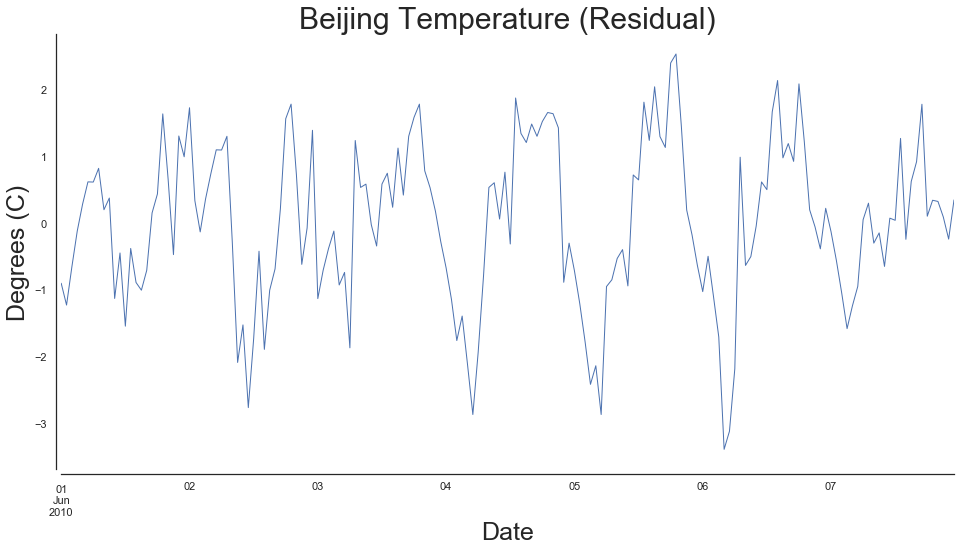

In [13]:
# Plot one month's temperature data
fig, ax = plt.subplots(figsize=(16, 8))

residual[start:end].plot(lw=1, alpha=1)

ax.set_title('Beijing Temperature (Residual)',size=30)
ax.set_xlabel('Date',size=25)
ax.set_ylabel('Degrees (C)',size=25)

sns.despine(offset=5)#, trim=True)

## Confusion Matrix

In [31]:
def confusion(test, predict, labels, title='Confusion Matrix'):
    '''
        test: true label of test data, must be one dimensional
        predict: predicted label of test data, must be one dimensional
        labels: list of label names, ie: ['positive', 'negative']
        title: plot title
    '''

    bins = len(labels)
    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=labels, columns=labels )
    
    # Display heatmap and add decorations
    fig, ax=plt.subplots(figsize=(10,8))
    hm = sns.heatmap(pd_pts, annot=True, fmt="d",annot_kws={"fontsize":30}, ax=ax)    
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    hm.axes.set_title(title, fontsize=30)
    hm.axes.set_xlabel('Predicted', fontsize=30)
    hm.axes.set_ylabel('Actual', fontsize=30)

    return None

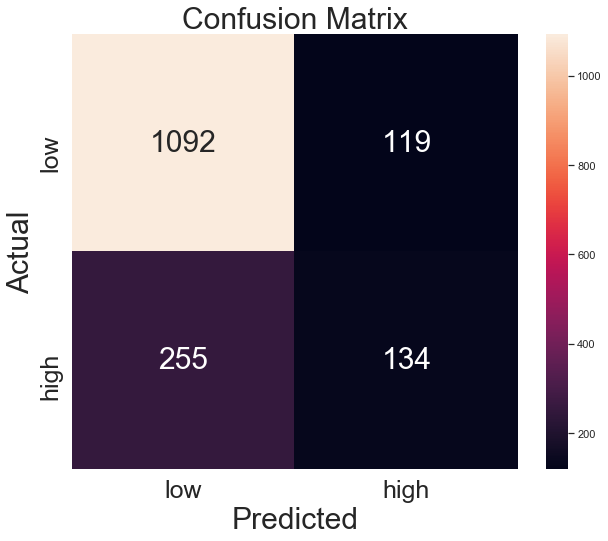

In [34]:
from sklearn.tree import DecisionTreeClassifier
adult_data = pd.read_csv('adult_income.csv')

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Encode Sex column to numerical value
adult_data['Sex_code'] = LabelEncoder().fit_transform(adult_data.Sex)

data = adult_data[['Age', 'HoursPerWeek', 'CapitalGain', 'Sex_code']]
label = adult_data['Label']

from sklearn.model_selection import train_test_split

d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)

adult_model = DecisionTreeClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)
predicted = adult_model.predict(d_test)

confusion(l_test, predicted, ['low', 'high'], title='Confusion Matrix')
